# Trined Model Evalution

In [1]:
# Go to project root folder
import os
os.chdir("../")
%pwd

'/workspaces/chest-x-ray-diagnosis'

In [2]:
# Set environment variables
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf

tf.get_logger().setLevel('ERROR')
tf.random.set_seed(42)

from pathlib import Path

import matplotlib.pyplot as plt
import mlflow
import pandas as pd
import seaborn as sns
from hydra import compose, initialize
from sklearn.metrics import classification_report, multilabel_confusion_matrix

from src.utils.utils import plot_auc_curve
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor
from src.weighted_loss.weighted_loss import get_weighted_loss


2025-03-23 14:00:47.464024: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742738447.476926  291716 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742738447.481030  291716 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# https://gist.github.com/bdsaglam/586704a98336a0cf0a65a6e7c247d248

with initialize(version_base=None, config_path="../conf"):
    cfg = compose(config_name="config")
    print(cfg.DATASET_DIRS.TRAIN_IMAGES_DIR)

datasets/sample/sample/images


In [4]:
OUPUT_DIR = Path(cfg.OUTPUTS.OUPUT_DIR)

In [5]:
%matplotlib inline

# auto reload libs
%load_ext autoreload
%autoreload 2

In [6]:
found_gpu = tf.config.list_physical_devices('GPU')
if not found_gpu:
    raise Exception("No GPU found")
found_gpu, tf.__version__

([PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')], '2.18.0')

In [7]:
CLASSES_NAME = ['Atelectasis','Effusion','Infiltration', 'Mass', 'No Finding']

## Loading Data

In [8]:
from src.data_loader.chest_x_ray_preprocessor import ChestXRayPreprocessor

test_prorcessor  = ChestXRayPreprocessor(cfg, labels=CLASSES_NAME)
_, test_ds, _, _, _= test_prorcessor.get_training_and_validation_datasets()


2025-03-23 14:00:52,494 — src.data_loader.chest_x_ray_preprocessor — INFO — Getting training and validation datasets with batch size:None
2025-03-23 14:00:52,496 — src.data_loader.chest_x_ray_preprocessor — INFO — Loading and preprocessing dataframe
2025-03-23 14:00:52,510 — src.data_loader.chest_x_ray_preprocessor — INFO — Cleaning up training dataframe
2025-03-23 14:00:52,540 — src.data_loader.chest_x_ray_preprocessor — INFO — Loaded dataframe with shape: (5606, 2) and 5606 rows
2025-03-23 14:00:52,560 — src.data_loader.chest_x_ray_preprocessor — INFO — training split: 3947 and validation split: 987


I0000 00:00:1742738452.473302  291716 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6967 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:0a:00.0, compute capability: 8.6


2025-03-23 14:00:53,444 — src.data_loader.chest_x_ray_preprocessor — INFO — Training dataset loaded and Augmentation applied
2025-03-23 14:00:53,498 — src.data_loader.chest_x_ray_preprocessor — INFO — Validationdataset loaded and Augmentation applied
2025-03-23 14:00:53,500 — src.data_loader.chest_x_ray_preprocessor — INFO — Preparing training dataset with augmentation


In [9]:
for batch in test_ds.take(1):
    images, labels = batch
    print(images.shape, labels.shape)
    print(images[0].shape, images[0].numpy().min(), images[0].numpy().max(), labels[0])

(32, 512, 512, 3) (32, 5)
(512, 512, 3) 0.0 255.0 tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


## Load the Trained model 

In [10]:
import numpy as np

# Take a batch of images and labels
test_images = []
y_true = []
for image, label in test_ds.unbatch().as_numpy_iterator():
    # for image, label in zip(images, labels):
    test_images.append(image.astype(np.uint8))
    y_true.append(label.astype(int))

y_true = np.array(y_true)
y_true[:10]

array([[0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 1, 1, 0, 0],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1]])

## Loading keras model

In [13]:
from src.weighted_loss.focal_loss import focal_loss
tf_model =  tf.keras.models.load_model('exported_models/my_densenet/checkpoints/best_build_DenseNet121-weighted_loss.keras' )                                       

In [14]:
tf_y_pred_prob = tf_model.predict(test_ds)
tf_y_pred_prob[:10]

I0000 00:00:1742738519.978229  291846 cuda_dnn.cc:529] Loaded cuDNN version 90701


31/31 [==============================] - 16s 372ms/step


array([[0.4478385 , 0.4847848 , 0.3269486 , 0.4721926 , 0.30179647],
       [0.6105686 , 0.32971692, 0.28887266, 0.39873713, 0.84220064],
       [0.20671472, 0.13596767, 0.13170533, 0.2094605 , 0.94036484],
       [0.654509  , 0.6103518 , 0.80050325, 0.24989061, 0.645112  ],
       [0.26492128, 0.06620001, 0.053229  , 0.39887968, 0.9812088 ],
       [0.1933136 , 0.2023061 , 0.2769269 , 0.16134036, 0.94913286],
       [0.8192719 , 0.51897883, 0.24869274, 0.253433  , 0.63178366],
       [0.27080724, 0.15113127, 0.04850243, 0.21538033, 0.9363991 ],
       [0.5259573 , 0.24399069, 0.47822562, 0.25441438, 0.93013626],
       [0.22851902, 0.15970011, 0.24342157, 0.8184274 , 0.74744976]],
      dtype=float32)

In [15]:
tf_y_pred = (tf_y_pred_prob >= 0.5).astype(int)
tf_y_pred[:10]

array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 1, 1]])

In [16]:
tf_report = classification_report(y_true,
                    tf_y_pred, 
                    target_names=CLASSES_NAME)
print(tf_report)

              precision    recall  f1-score   support

 Atelectasis       0.19      0.71      0.29       102
    Effusion       0.32      0.52      0.40       129
Infiltration       0.32      0.34      0.33       193
        Mass       0.10      0.51      0.16        57
  No Finding       0.65      0.93      0.77       609

   micro avg       0.41      0.74      0.52      1090
   macro avg       0.32      0.60      0.39      1090
weighted avg       0.48      0.74      0.57      1090
 samples avg       0.50      0.76      0.57      1090



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
y_true[:10], tf_y_pred[:10]

(array([[0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 1, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1]]),
 array([[0, 0, 0, 0, 0],
        [1, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [1, 1, 1, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [1, 1, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [1, 0, 0, 0, 1],
        [0, 0, 0, 1, 1]]))

In [18]:
CLASSES_NAME

['Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'No Finding']

In [19]:
tf_cm = multilabel_confusion_matrix(y_true=y_true, 
                                                       y_pred=tf_y_pred)

for i in range(len(CLASSES_NAME)):
    print(f"{CLASSES_NAME[i]}:\n")
    print(tf_cm[i, :, :])
    print("------------")

Atelectasis:

[[569 316]
 [ 30  72]]
------------
Effusion:

[[717 141]
 [ 62  67]]
------------
Infiltration:

[[655 139]
 [128  65]]
------------
Mass:

[[659 271]
 [ 28  29]]
------------
No Finding:

[[ 78 300]
 [ 40 569]]
------------


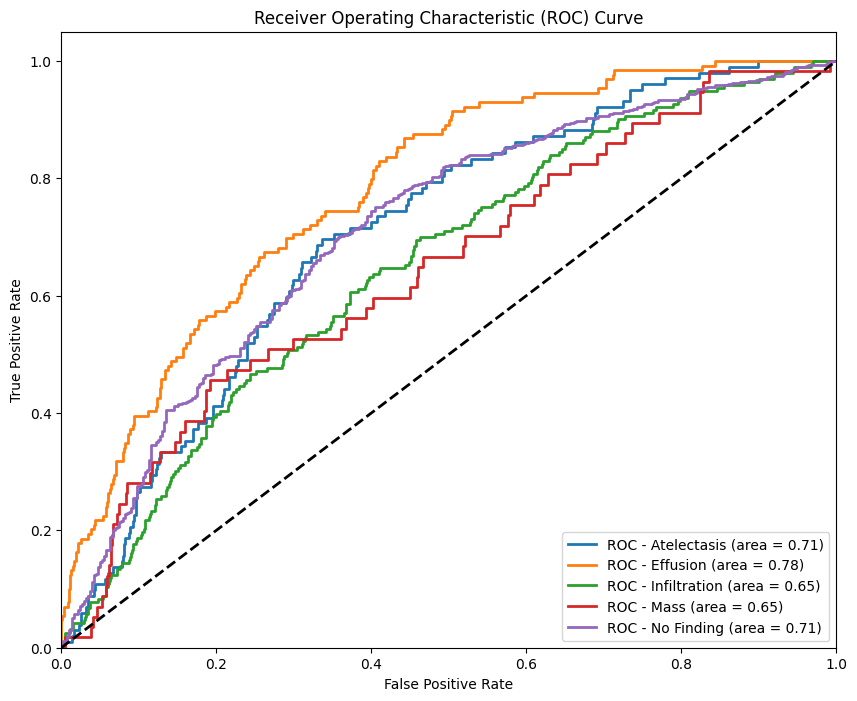

In [20]:
plot_auc_curve(output_dir=OUPUT_DIR, 
                class_name_list=CLASSES_NAME, 
                y_true=y_true, 
                y_prob_pred=tf_y_pred_prob)

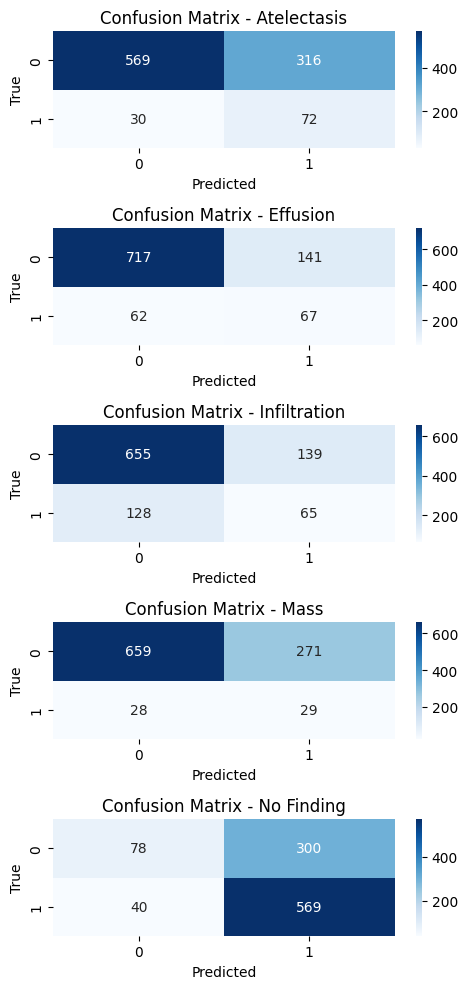

In [ ]:
# Multi-label Confusion Matrix
num_classes = len(CLASSES_NAME)
fig, axes = plt.subplots(num_classes,1, figsize=(num_classes, 10))
for i, class_label in enumerate(CLASSES_NAME):
    # cm = confusion_matrix(y_true[:, i], y_pred_pyfunc[:, i])
    sns.heatmap(tf_cm[i, :, :], annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')
    axes[i].set_title(f'Confusion Matrix - {class_label}')

plt.tight_layout()
plt.show()
plt.close(fig)

In [42]:
def plot_random_images(test_images, test_labels, y_prob_pred, class_names, num_images=9):
    """
    Plots a random sample of images, their true labels, and predicted labels from a TensorFlow dataset.

    Args:
        test_images: A list or numpy array of test images.
        test_labels: A list or numpy array of true test labels (one-hot encoded or multi-label).
        y_prob_pred: A list or numpy array of predicted probabilities for each class.
        class_names: A list of class names corresponding to the label indices.
        num_images: The number of images to plot (default: 9).
    """

    # Ensure inputs are numpy arrays
    test_images = np.array(test_images)
    test_labels = np.array(test_labels)
    y_prob_pred = np.array(y_prob_pred)

    # Check if the number of images is valid
    if num_images > len(test_images):
        num_images = len(test_images)
        print(f"Warning: num_images exceeds the number of available images. Plotting {num_images} images instead.")

    # Randomly select indices for plotting
    indices = np.random.choice(len(test_images), num_images, replace=False)

    # Create a figure and axes for the plot
    plt.figure(figsize=(10, 10))

    # Iterate through the selected indices and plot the images
    for i, index in enumerate(indices):
        ax = plt.subplot(3, 3, i + 1)  # Create a grid of subplots
        plt.imshow(test_images[index], cmap='gray')  # Display the image

        # Get true label indices
        true_indices = np.where(test_labels[index] == 1)[0]
        true_class_names = [class_names[j] for j in true_indices]
        true_class_names_str = '-'.join(true_class_names) if true_class_names else 'No Finding'

        # Get predicted label indices (using a threshold of 0.5)
        pred_indices = np.where(y_prob_pred[index] >= 0.5)[0]
        pred_class_names = [class_names[j] for j in pred_indices]
        pred_class_names_str = '-'.join(pred_class_names) if pred_class_names else 'No Finding'

        # Display the true and predicted labels
        plt.title(f"True: {true_class_names_str}\nPred: {pred_class_names_str}")
        plt.axis("off")  # Hide the axes

    plt.tight_layout()
    plt.show()

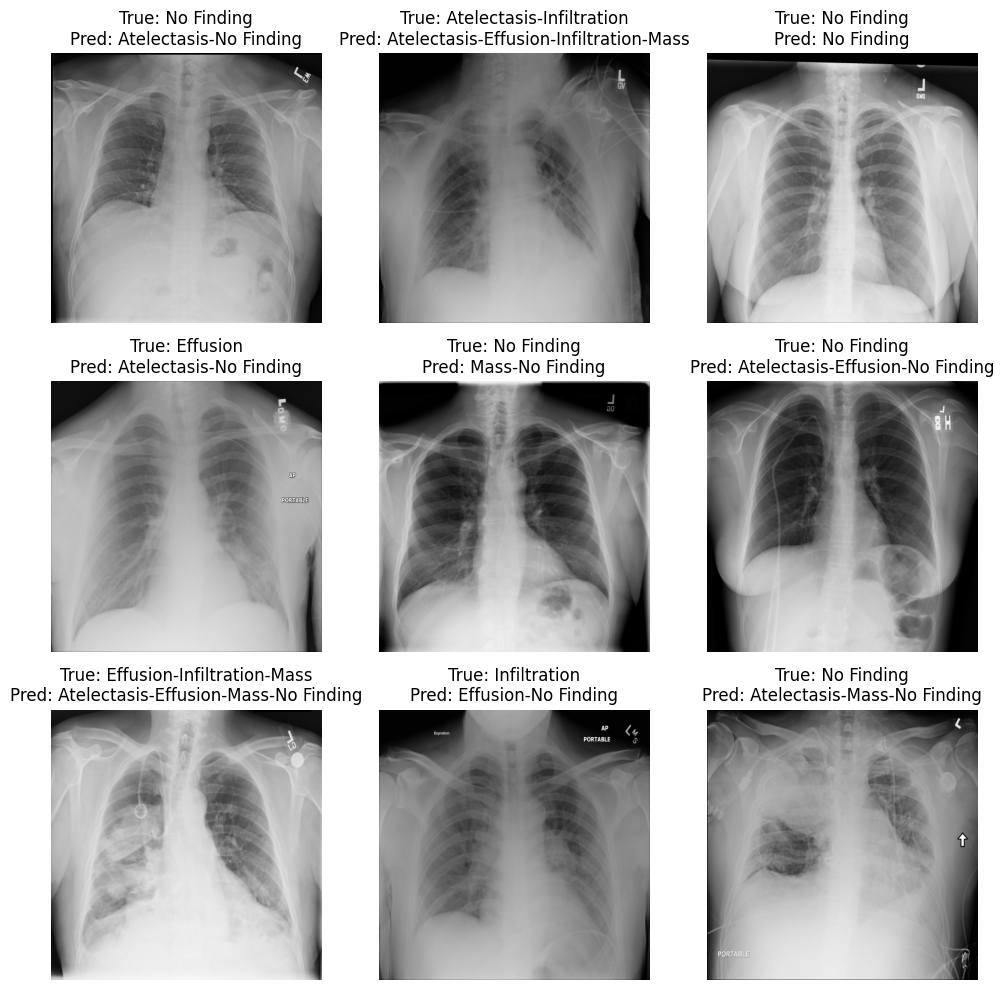

In [43]:
plot_random_images(test_images, y_true, tf_y_pred, CLASSES_NAME)

## Load mlflow model

In [36]:
model_uri = 'runs:/a65f9f037cc3466aa8289dbb2f95307c/model'
# The model is logged with an input example
mlflow_model =mlflow.tensorflow.load_model(model_uri)

In [37]:
y_pred_pyfunc_prob = mlflow_model.predict(test_ds)
y_pred_pyfunc = (y_pred_pyfunc_prob >= 0.5).astype(np.uint8)
y_pred_pyfunc[:10]

31/31 [==============================] - 6s 171ms/step


array([[0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 1, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 1, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 1],
       [0, 0, 0, 1, 1]], dtype=uint8)

In [38]:
py_func_report = classification_report(y_true,
                    y_pred_pyfunc, 
                    target_names=CLASSES_NAME)
print(py_func_report)

              precision    recall  f1-score   support

 Atelectasis       0.19      0.71      0.29       102
    Effusion       0.32      0.52      0.40       129
Infiltration       0.32      0.34      0.33       193
        Mass       0.10      0.51      0.16        57
  No Finding       0.65      0.93      0.77       609

   micro avg       0.41      0.74      0.52      1090
   macro avg       0.32      0.60      0.39      1090
weighted avg       0.48      0.74      0.57      1090
 samples avg       0.50      0.76      0.57      1090



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


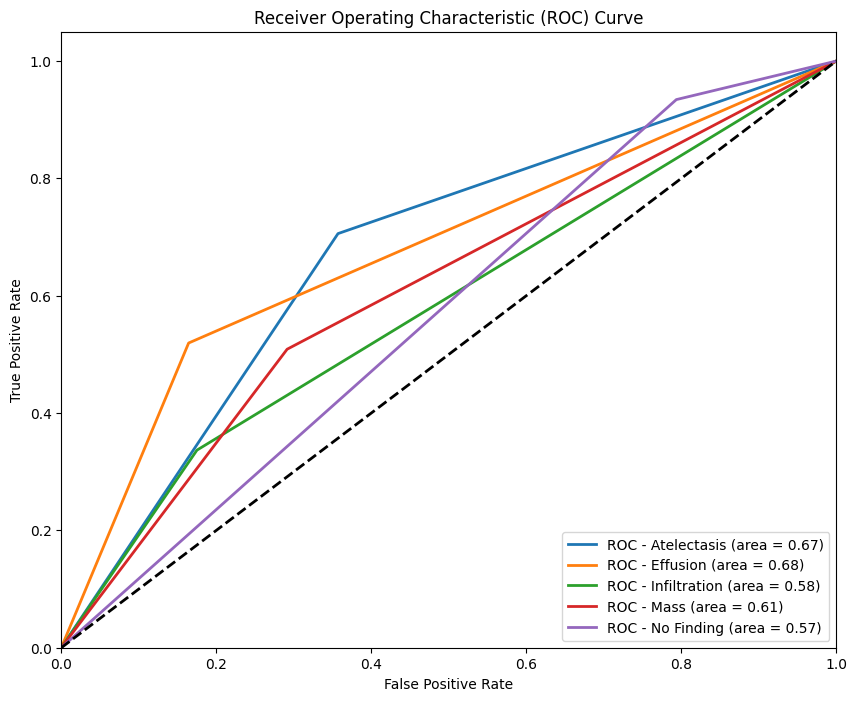

In [39]:
plot_auc_curve(output_dir=OUPUT_DIR, 
                class_name_list=CLASSES_NAME, 
                y_true=y_true, 
                y_prob_pred=y_pred_pyfunc)

[0 0 0 0 1]
[1 0 0 0 0]
[0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 0 1]
[0 0 0 0 1]
[0 1 1 0 0]
[0 0 0 0 1]


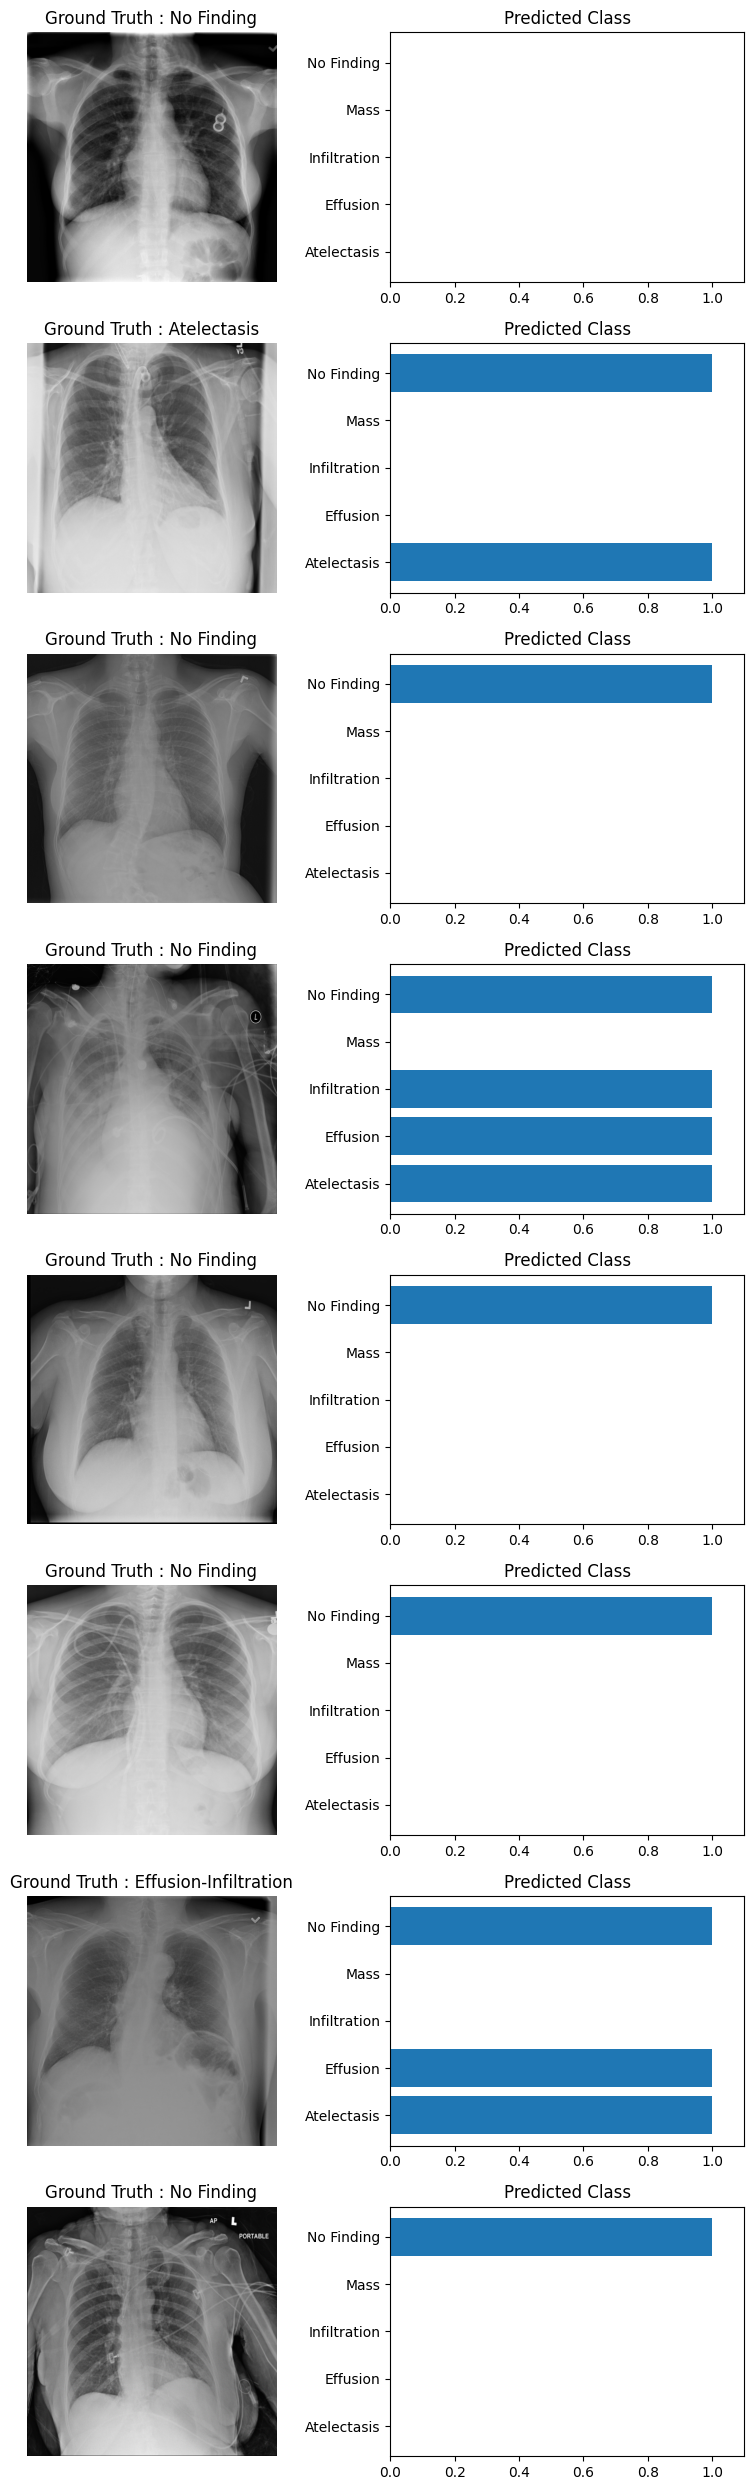

In [40]:
fig, ax = plt.subplots(figsize=(8,25), ncols=2, nrows=8)

for idx in range(8):
    test_image = test_images[idx]
    _y_true = y_true[idx]
    print(_y_true)
    y_pred = y_pred_pyfunc[idx]
    y_true_labels = np.where(_y_true==1)[0]
    y_true_class_name = [CLASSES_NAME[i] for i in y_true_labels]
    if len(y_true_labels) == 0:
        title = '-'
    else : 
        title = '-'.join(y_true_class_name)
    #idx = idx//2
    ax[idx,0].imshow(test_image)
    ax[idx,0].set_title('Ground Truth : {}'.format(title))
    ax[idx,0].axis('off')
    ax[idx,1].barh(CLASSES_NAME, y_pred)
    ax[idx,1].set_yticks(CLASSES_NAME)
    ax[idx,1].set_yticklabels(CLASSES_NAME)
    ax[idx,1].set_title('Predicted Class')
    ax[idx,1].set_xlim(0, 1.1)

plt.tight_layout()
plt.show()

TypeError: unsupported operand type(s) for /: 'str' and 'str'

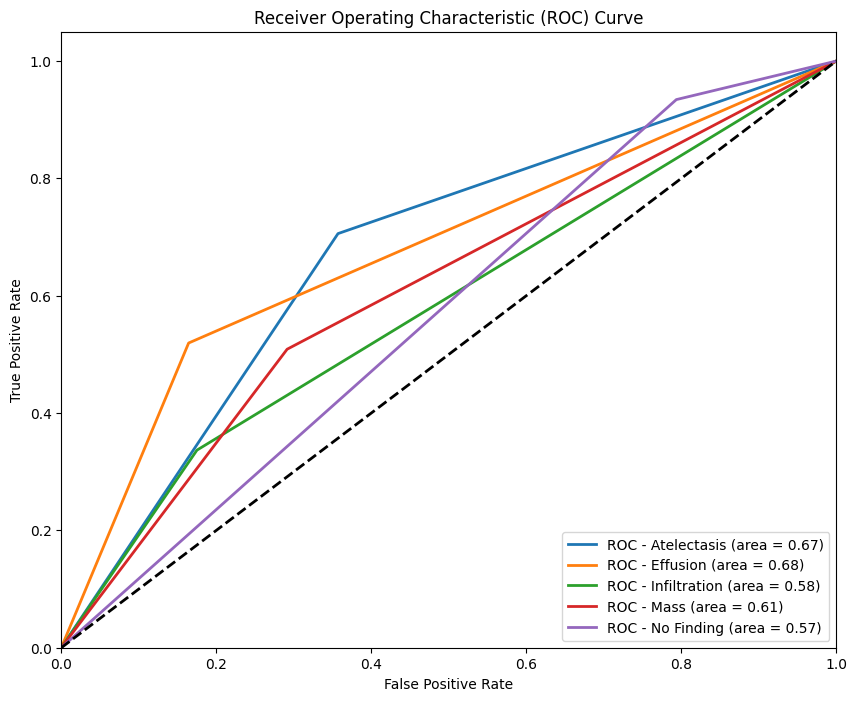

In [41]:
plot_auc_curve(output_dir='resources', 
               class_name_list=CLASSES_NAME, 
               y_true=y_true, 
               y_prob_pred=y_pred_pyfunc)